In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
import pickle
import librosa
import pandas as pd
import numpy as np
import IPython.display as ipd
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
labels = ["alarm off", "alarm on", "camera off", "camera on", "door close", "door open", "fan decrease", "fan increase", "fan off", "fan on", "fridge off", "fridge on", "lights off", "lights on", "speaker decrease", "speaker increase", "speaker off", "speaker on", "tv off", "tv on"]

In [ ]:
def plot_confusion_matrix(confusion_matrix, labels = labels):
    """
    plots the confusion matrix
    """
    # matrix = confusion_matrix(y_true, y_pred)
    matrix = confusion_matrix
    fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");
def plot_loss(history):

    # plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()

def plot_accuracy(history):
    # plt.figure(figsize=(10, 7))
    plt.plot(history.history['accuracy'], c="darkblue")
    plt.plot(history.history['val_accuracy'], c="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.2)
    plt.show()

In [ ]:
os.chdir("/content/drive/MyDrive/final")

In [ ]:
pickle_path = 'data.pkl'

with open(pickle_path, 'rb') as file:
    data = pickle.load(file)

Xtrain = data['Xtrain']
Xtest = data['Xtest']
Xval = data['Xval']
ytrain = data['ytrain']
ytest = data['ytest']
yval = data['yval']

Xtrain.shape,Xtest.shape

((24381, 126, 10, 1), (711, 126, 10, 1))

In [ ]:
Xval.shape

(1005, 126, 10, 1)

In [ ]:

import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Flatten, Activation, Add
from tensorflow.keras.layers import Dense, Dropout, Softmax, TimeDistributed, LSTM
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, callbacks


# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

In [ ]:
main_input = Input(shape=(126, 10, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu', use_bias = False)(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(16, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(32, 3, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (2,2))(x)

x = Conv2D(128, 2, padding='same', activation='relu', use_bias = False)(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)

intent_output = Dense(20, activation='softmax', name='intent_output', use_bias = False)(x)

model = Model(inputs=main_input, outputs=intent_output)

optim = Adam(learning_rate=1e-3)

model.compile(optimizer = optim, loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 126, 10, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 126, 10, 16)       144       
                                                                 
 batch_normalization (BatchN  (None, 126, 10, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 10, 16)       1024      
                                                                 
 batch_normalization_1 (Batc  (None, 126, 10, 16)      64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 5, 16)        0     

In [ ]:
history = model.fit(Xtrain,ytrain, validation_data = (Xval,yval), epochs = 80,workers = 6, max_queue_size = 10,use_multiprocessing = True,batch_size=32,callbacks=[early_stopping])

Epoch 1/80
762/762 [==============================] - 17s 7ms/step - loss: 2.7664 - accuracy: 0.1306 - val_loss: 2.2824 - val_accuracy: 0.2458
Epoch 2/80
762/762 [==============================] - 5s 7ms/step - loss: 1.6774 - accuracy: 0.4213 - val_loss: 1.0354 - val_accuracy: 0.6488
Epoch 3/80
762/762 [==============================] - 4s 6ms/step - loss: 1.0454 - accuracy: 0.6387 - val_loss: 0.7698 - val_accuracy: 0.7403
Epoch 4/80
762/762 [==============================] - 5s 6ms/step - loss: 0.8154 - accuracy: 0.7232 - val_loss: 0.6312 - val_accuracy: 0.7920
Epoch 5/80
762/762 [==============================] - 5s 7ms/step - loss: 0.6962 - accuracy: 0.7626 - val_loss: 0.6870 - val_accuracy: 0.7801
Epoch 6/80
762/762 [==============================] - 4s 6ms/step - loss: 0.6171 - accuracy: 0.7925 - val_loss: 0.5132 - val_accuracy: 0.8299
Epoch 7/80
762/762 [==============================] - 5s 7ms/step - loss: 0.5667 - accuracy: 0.8112 - val_loss: 0.4751 - val_accuracy: 0.8547
Epoch

In [ ]:
model.evaluate(Xtest,ytest)

23/23 [==============================] - 0s 10ms/step - loss: 0.5213 - accuracy: 0.8790


[0.5212678909301758, 0.8790435791015625]

In [ ]:
loss, accuracy = model.evaluate(Xtest, ytest)

print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

23/23 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.8790
Validation Loss: 0.5212678909301758
Validation Accuracy: 0.8790435791015625


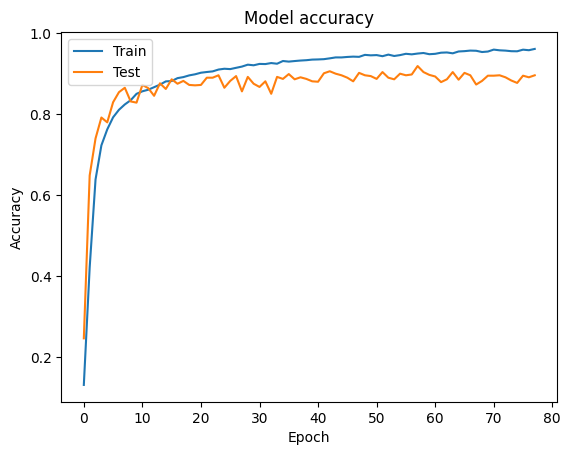

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

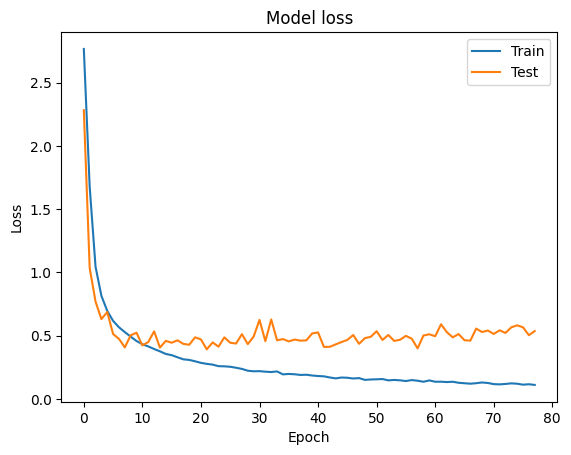

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(Xtest)
# y_pred.shape

y_pred = np.argmax(y_pred, axis=1)
y_true = ytest

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

23/23 [==============================] - 0s 2ms/step


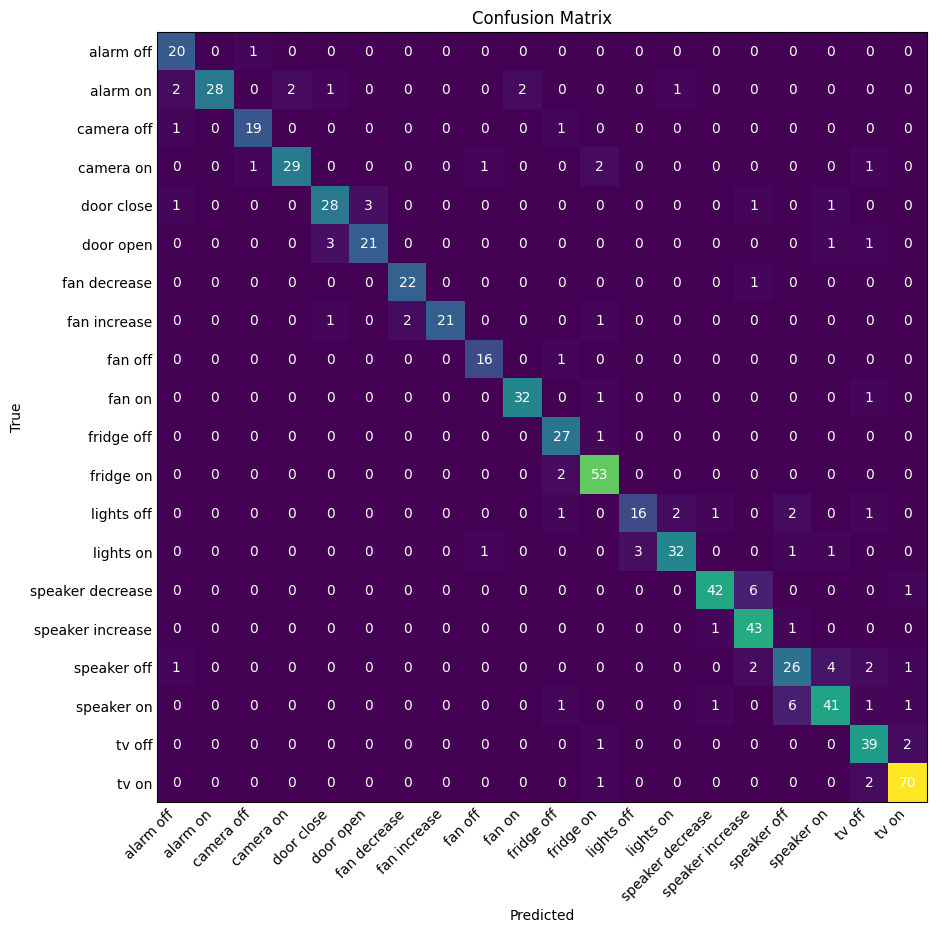

In [ ]:
plot_confusion_matrix(cm)

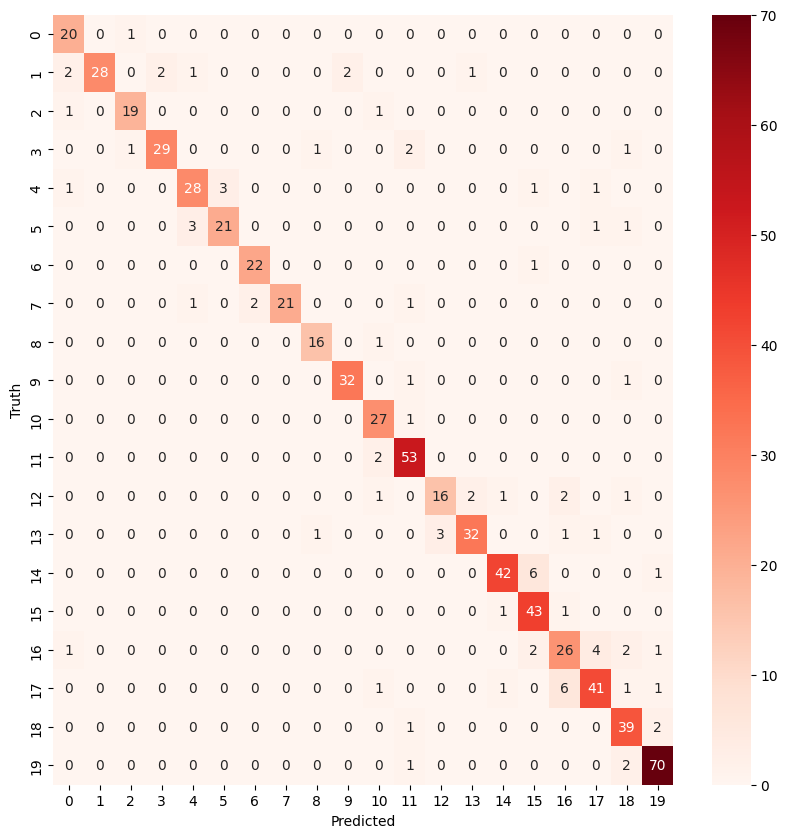

In [ ]:

import seaborn as sns
plt.figure(figsize=(10, 10))

# # Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt="d",cmap='Reds')

plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## allow bias

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

main_input = Input(shape=(126, 10, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu')(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(16, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalMaxPooling2D()(x)

x = Dropout(0.1)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

intent_output = Dense(20, activation='softmax', name='intent_output')(x)

model = Model(inputs=main_input, outputs=intent_output)

optim = Adam(learning_rate=1e-3)

model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 126, 10, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 10, 16)       160       
                                                                 
 batch_normalization_5 (Batc  (None, 126, 10, 16)      64        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 10, 16)       1040      
                                                                 
 batch_normalization_6 (Batc  (None, 126, 10, 16)      64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 5, 16)        0   

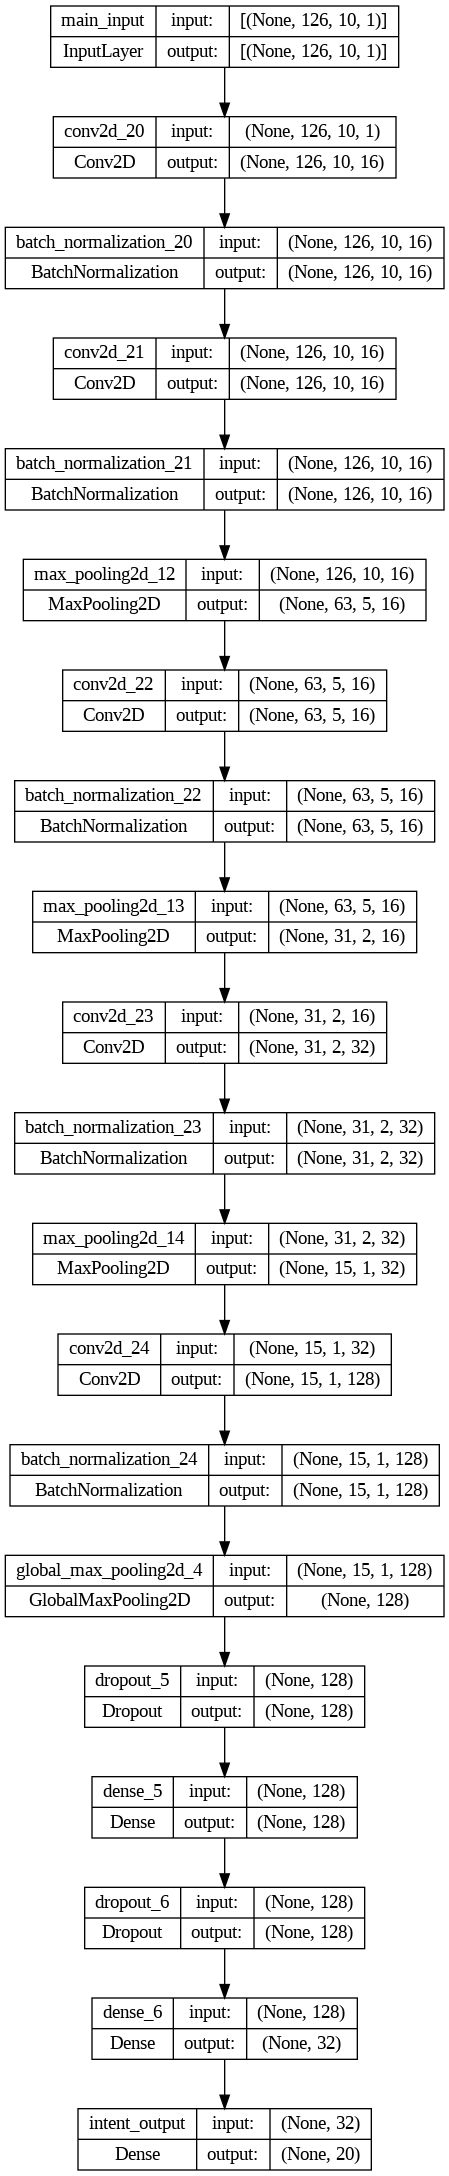

In [ ]:
tf.keras.utils.plot_model(model,show_shapes= True)

In [ ]:
history = model.fit(Xtrain,ytrain, validation_data = (Xval,yval), epochs = 80,workers = 6, max_queue_size = 10,use_multiprocessing = True,batch_size=32,callbacks=[early_stopping])

Epoch 1/80
762/762 [==============================] - 11s 9ms/step - loss: 2.9888 - accuracy: 0.0863 - val_loss: 2.9429 - val_accuracy: 0.0955
Epoch 2/80
762/762 [==============================] - 5s 6ms/step - loss: 2.6858 - accuracy: 0.1546 - val_loss: 2.0651 - val_accuracy: 0.2905
Epoch 3/80
762/762 [==============================] - 6s 8ms/step - loss: 1.8054 - accuracy: 0.3595 - val_loss: 1.4254 - val_accuracy: 0.4667
Epoch 4/80
762/762 [==============================] - 5s 7ms/step - loss: 1.3637 - accuracy: 0.4761 - val_loss: 1.1240 - val_accuracy: 0.5383
Epoch 5/80
762/762 [==============================] - 5s 7ms/step - loss: 1.1379 - accuracy: 0.5563 - val_loss: 0.8801 - val_accuracy: 0.6547
Epoch 6/80
762/762 [==============================] - 6s 8ms/step - loss: 0.9310 - accuracy: 0.6601 - val_loss: 0.7165 - val_accuracy: 0.7333
Epoch 7/80
762/762 [==============================] - 5s 6ms/step - loss: 0.7891 - accuracy: 0.7235 - val_loss: 0.5575 - val_accuracy: 0.8040
Epoch

In [ ]:
loss, accuracy = model.evaluate(Xtest, ytest)

print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

23/23 [==============================] - 0s 10ms/step - loss: 0.6144 - accuracy: 0.8411
Validation Loss: 0.6143750548362732
Validation Accuracy: 0.8410689234733582


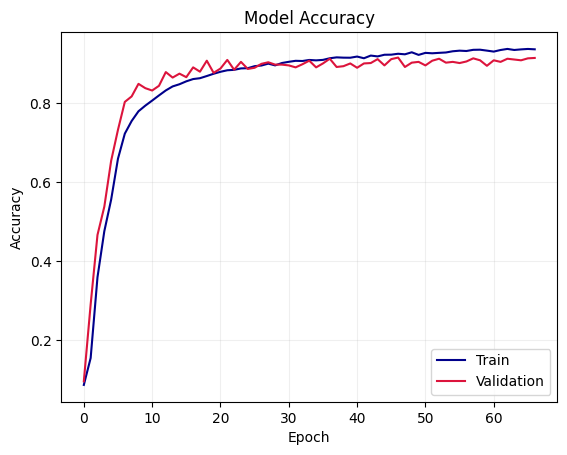

In [ ]:
plot_accuracy(history)

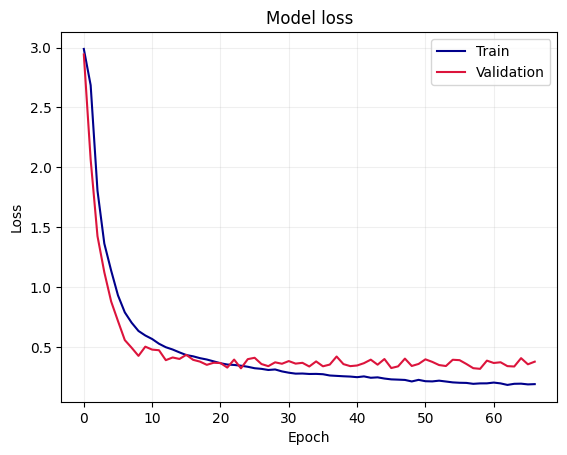

In [ ]:
plot_loss(history)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(Xtest)
# y_pred.shape

y_pred = np.argmax(y_pred, axis=1)
y_true = ytest

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

23/23 [==============================] - 0s 2ms/step


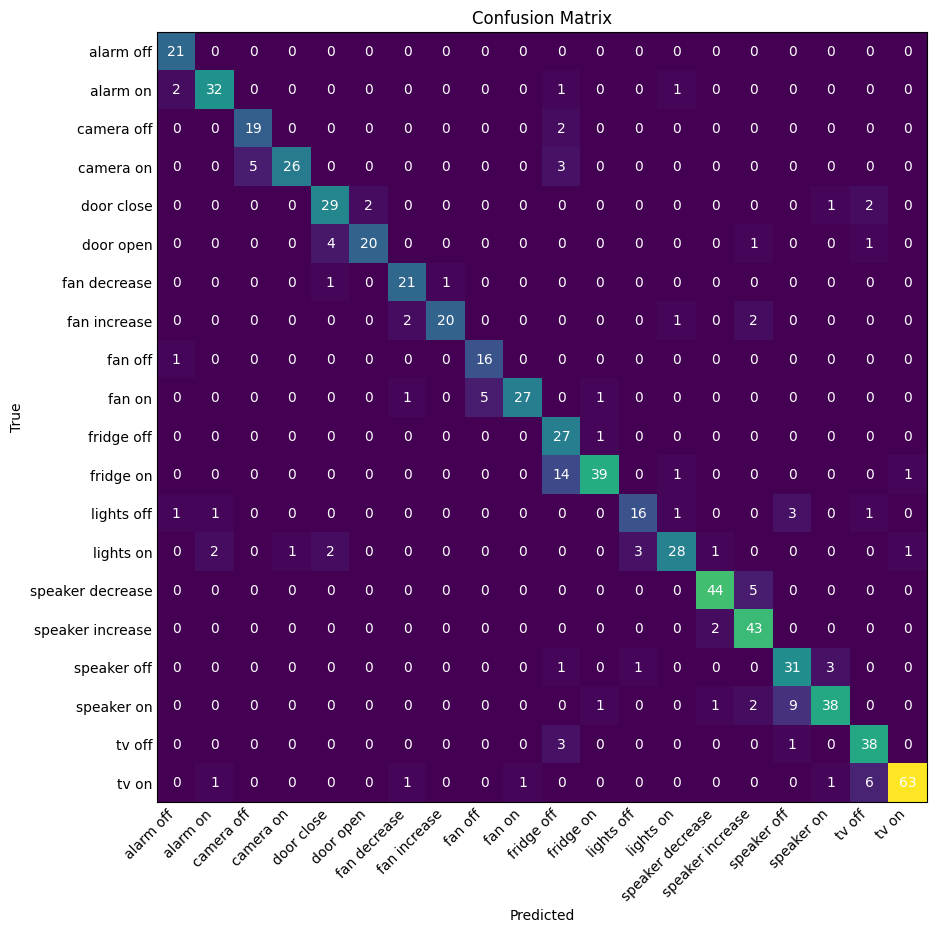

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
model.save("/content/drive/MyDrive/models_lug/lug.h5")

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = "lug.tflite"
open(tflite_model_name, "wb").write(tflite_model)

188964

## allow bias

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

main_input = Input(shape=(126, 10, 1), name='main_input')

x = Conv2D(16, 3, padding='same', activation='relu')(main_input)
x = BatchNormalization()(x)

x = Conv2D(16, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(16, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, 2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# x = GlobalMaxPooling2D()(x)
x = Flatten()(x)

x = Dropout(0.1)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

intent_output = Dense(20, activation='softmax', name='intent_output')(x)

model = Model(inputs=main_input, outputs=intent_output)

optim = Adam(learning_rate=1e-3)

model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 126, 10, 1)]      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 10, 16)       160       
                                                                 
 batch_normalization_10 (Bat  (None, 126, 10, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 10, 16)       1040      
                                                                 
 batch_normalization_11 (Bat  (None, 126, 10, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 5, 16)        0   

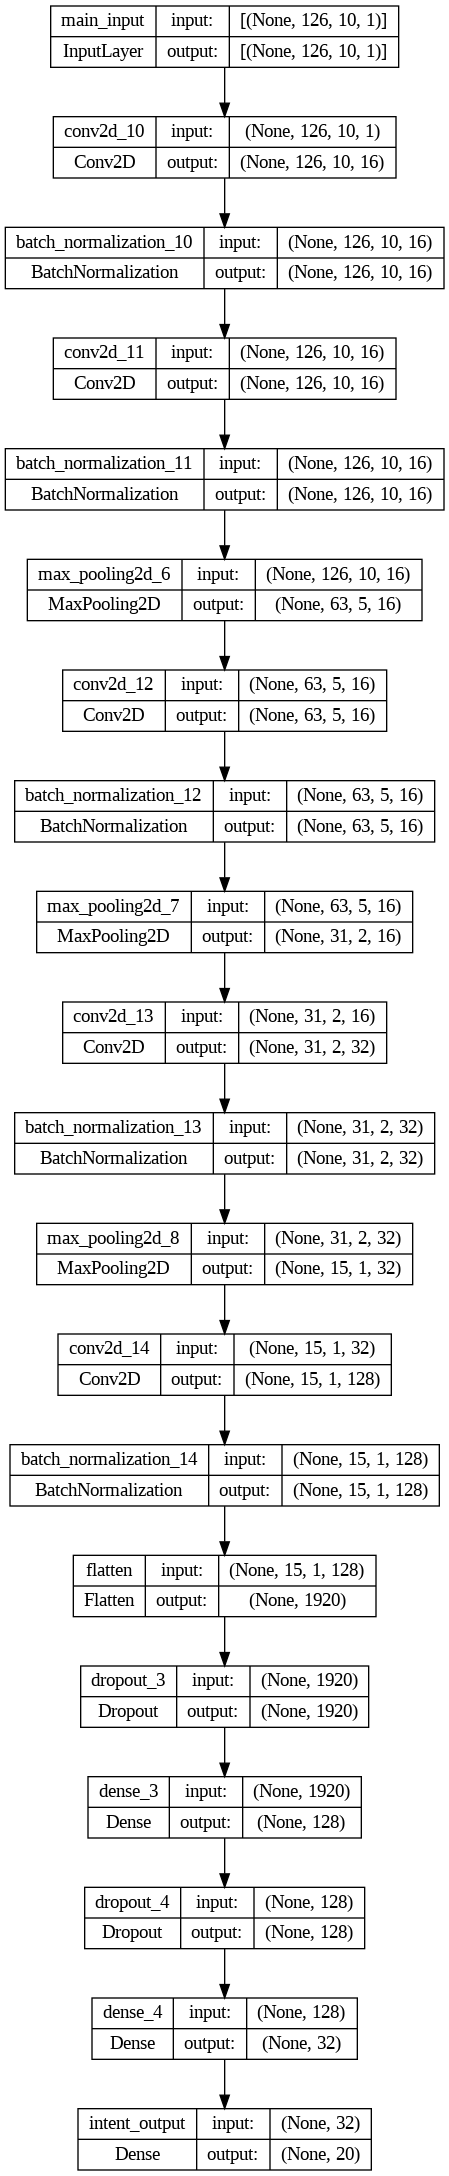

In [ ]:
tf.keras.utils.plot_model(model,show_shapes= True)

In [ ]:
history = model.fit(Xtrain,ytrain, validation_data = (Xval,yval), epochs = 80,workers = 6, max_queue_size = 10,use_multiprocessing = True,batch_size=32,callbacks=[early_stopping])

Epoch 1/80
762/762 [==============================] - 11s 7ms/step - loss: 2.7539 - accuracy: 0.1428 - val_loss: 2.3376 - val_accuracy: 0.2438
Epoch 2/80
762/762 [==============================] - 6s 7ms/step - loss: 1.9301 - accuracy: 0.3433 - val_loss: 1.6591 - val_accuracy: 0.4507
Epoch 3/80
762/762 [==============================] - 5s 7ms/step - loss: 1.3854 - accuracy: 0.5114 - val_loss: 1.4016 - val_accuracy: 0.5393
Epoch 4/80
762/762 [==============================] - 5s 7ms/step - loss: 1.0662 - accuracy: 0.6203 - val_loss: 0.8970 - val_accuracy: 0.6945
Epoch 5/80
762/762 [==============================] - 6s 8ms/step - loss: 0.8652 - accuracy: 0.6953 - val_loss: 0.7652 - val_accuracy: 0.7403
Epoch 6/80
762/762 [==============================] - 5s 6ms/step - loss: 0.7221 - accuracy: 0.7463 - val_loss: 0.8310 - val_accuracy: 0.7214
Epoch 7/80
762/762 [==============================] - 7s 9ms/step - loss: 0.6283 - accuracy: 0.7804 - val_loss: 0.8855 - val_accuracy: 0.7353
Epoch

In [ ]:
loss, accuracy = model.evaluate(Xtest, ytest)

print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

23/23 [==============================] - 0s 3ms/step - loss: 0.8580 - accuracy: 0.8298
Validation Loss: 0.8580307960510254
Validation Accuracy: 0.8298171758651733


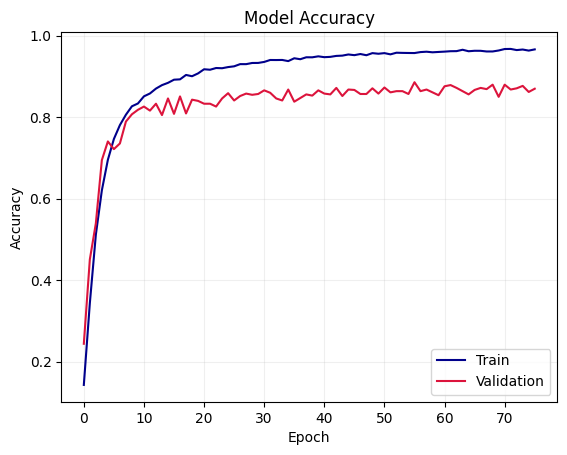

In [ ]:
plot_accuracy(history)

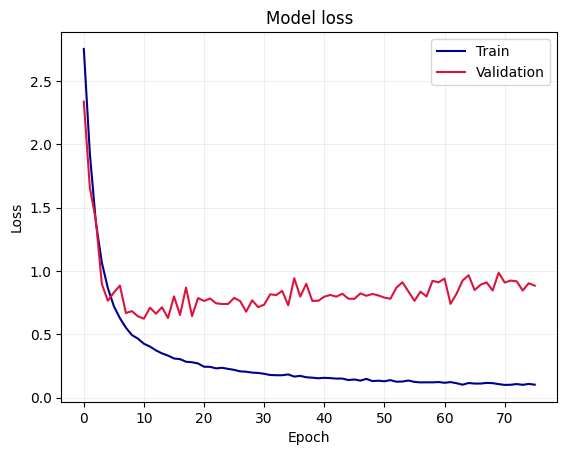

In [ ]:
plot_loss(history)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(Xtest)
# y_pred.shape

y_pred = np.argmax(y_pred, axis=1)
y_true = ytest

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

23/23 [==============================] - 0s 2ms/step


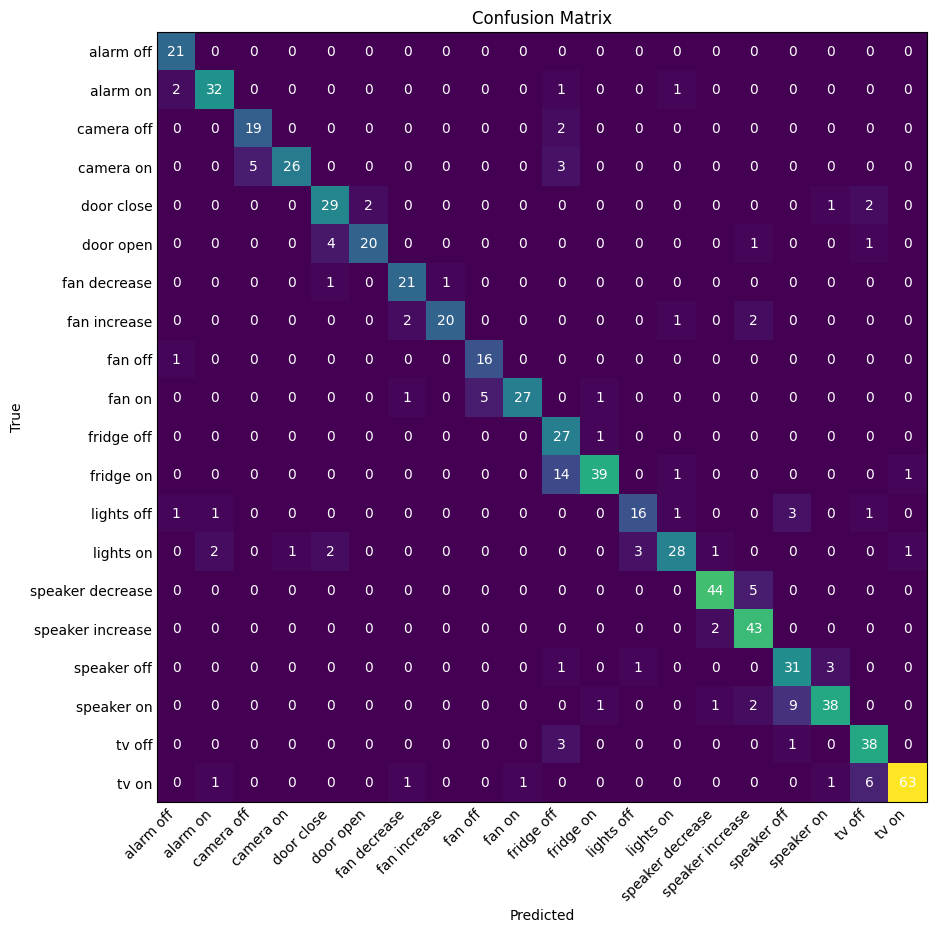

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
model.save("/content/drive/MyDrive/models_lug_aug_flat/lug.h5")

In [ ]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [ ]:
tflite_model_name = "lug_aug_flat.tflite"
open(tflite_model_name, "wb").write(tflite_model)

1106400